* Connecting to google drive and download the data

In [ ]:
import gdown
file_id = '1IB-Hvf3lmecMQUz-DapuYY2uBzbuyMP9'
output = 'fer.zip'  # Specify the desired output file name and extension.
gdown.download(f'https://drive.google.com/uc?id={file_id}', output)

Downloading...
From: https://drive.google.com/uc?id=1IB-Hvf3lmecMQUz-DapuYY2uBzbuyMP9
To: /content/fer.zip
100%|██████████| 76.4M/76.4M [00:01<00:00, 49.5MB/s]


'fer.zip'

In [ ]:
# https://drive.google.com/file/d/1GiotOkAD80bo6ephXuZJybl_xlvE_zFJ/view?usp=sharing
# https://drive.google.com/file/d/1coN0ZPLpW63H56lZR4DbE2WqDB_zpiw6/view?usp=sharing -- ck+
# https://drive.google.com/file/d/1IB-Hvf3lmecMQUz-DapuYY2uBzbuyMP9/view?usp=sharing -- fer2013

In [ ]:
import zipfile

# Specify the path to the downloaded zip file
zip_path = '/content/fer.zip'

# Specify the destination folder where you want to extract the contents
destination_folder = '/content/fer'

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all contents to the destination folder
    zip_ref.extractall(destination_folder)

print("File successfully unzipped.")

File successfully unzipped.


* New Method


In [ ]:
import os
import cv2
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np

In [ ]:
# Function to check if an image is black or white
def is_image_black_or_white(image_path, threshold=10):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mean_value = cv2.mean(image)[0]
    return mean_value < threshold or mean_value > 255 - threshold

# Function to filter out black and white images and preprocess the data
def preprocess_data(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    # Count the number of images in each class
    class_counts = {}
    total_images = 0

    for folder_name in os.listdir(input_folder):
        folder_path = os.path.join(input_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue
        class_counts[folder_name] = 0

        images = os.listdir(folder_path)
        total_images += len(images)

        for image_name in images:
            image_path = os.path.join(folder_path, image_name)

            if is_image_black_or_white(image_path):
                print("Black or white image found:", image_path)
                continue

            class_counts[folder_name] += 1
            output_subfolder = os.path.join(output_folder, folder_name)
            os.makedirs(output_subfolder, exist_ok=True)
            shutil.copy(image_path, output_subfolder)

    print("Total images before preprocessing:", total_images)
    print("Total images after preprocessing:", sum(class_counts.values()))

# Set the paths to your original data folders
train_data_folder = "/content/fer/images/train"
test_data_folder = "/content/fer/images/validation"

# Set the paths to the preprocessed data folders
preprocessed_train_folder = "/content/preprocessed_training"
preprocessed_test_folder = "/content/preprocessed_testing"

# Preprocess the training data
preprocess_data(train_data_folder, preprocessed_train_folder)

# Preprocess the testing data
preprocess_data(test_data_folder, preprocessed_test_folder)


Black or white image found: /content/fer/images/train/angry/11286.jpg
Black or white image found: /content/fer/images/train/angry/13402.jpg
Black or white image found: /content/fer/images/train/angry/15894.jpg
Black or white image found: /content/fer/images/train/angry/28601.jpg
Black or white image found: /content/fer/images/train/angry/6458.jpg
Black or white image found: /content/fer/images/train/angry/13148.jpg
Black or white image found: /content/fer/images/train/happy/29447.jpg
Black or white image found: /content/fer/images/train/happy/7629.jpg
Black or white image found: /content/fer/images/train/happy/20417.jpg
Black or white image found: /content/fer/images/train/fear/14279.jpg
Black or white image found: /content/fer/images/train/neutral/22927.jpg
Black or white image found: /content/fer/images/train/surprise/2059.jpg
Black or white image found: /content/fer/images/train/surprise/19238.jpg
Black or white image found: /content/fer/images/train/surprise/13988.jpg
Black or whit

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to the original training folder
original_folder = '/content/preprocessed_training'

# Path to the new training and validation folders
new_training_folder = '/content/train80'
new_validation_folder = '/content/val20'

# Define the ratio for splitting (e.g., 80% for training, 20% for validation)
train_ratio = 0.8

# Iterate through the original folder and its subdirectories
for root, dirs, files in os.walk(original_folder):
    for dir_name in dirs:
        dir_path = os.path.join(root, dir_name)
        new_train_dir = os.path.join(new_training_folder, dir_path[len(original_folder)+1:])
        new_val_dir = os.path.join(new_validation_folder, dir_path[len(original_folder)+1:])

        os.makedirs(new_train_dir, exist_ok=True)
        os.makedirs(new_val_dir, exist_ok=True)

        # Split images within the current subdirectory
        all_files = os.listdir(dir_path)
        train_files, val_files = train_test_split(all_files, train_size=train_ratio, random_state=42)

        for file in train_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(new_train_dir, file)
            shutil.copy(src, dst)

        for file in val_files:
            src = os.path.join(dir_path, file)
            dst = os.path.join(new_val_dir, file)
            shutil.copy(src, dst)


In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size and image input dimensions
batch_size = 32
input_shape = (48, 48, 3)  # Change to grayscale (1 channel)

# Flow training images from the preprocessed training folder
train_generator = train_datagen.flow_from_directory(
    new_training_folder,
    target_size=input_shape[:2],
    batch_size=batch_size,
    color_mode='rgb',  # Change to grayscale
    class_mode='categorical',
    shuffle=True
)

# Flow validation images from the preprocessed testing folder
validation_generator = test_datagen.flow_from_directory(
    new_validation_folder,
    target_size=input_shape[:2],
    batch_size=batch_size,
    color_mode='rgb',  # Change to grayscale
    class_mode='categorical',
    shuffle=False
)

Found 23040 images belonging to 7 classes.
Found 5766 images belonging to 7 classes.


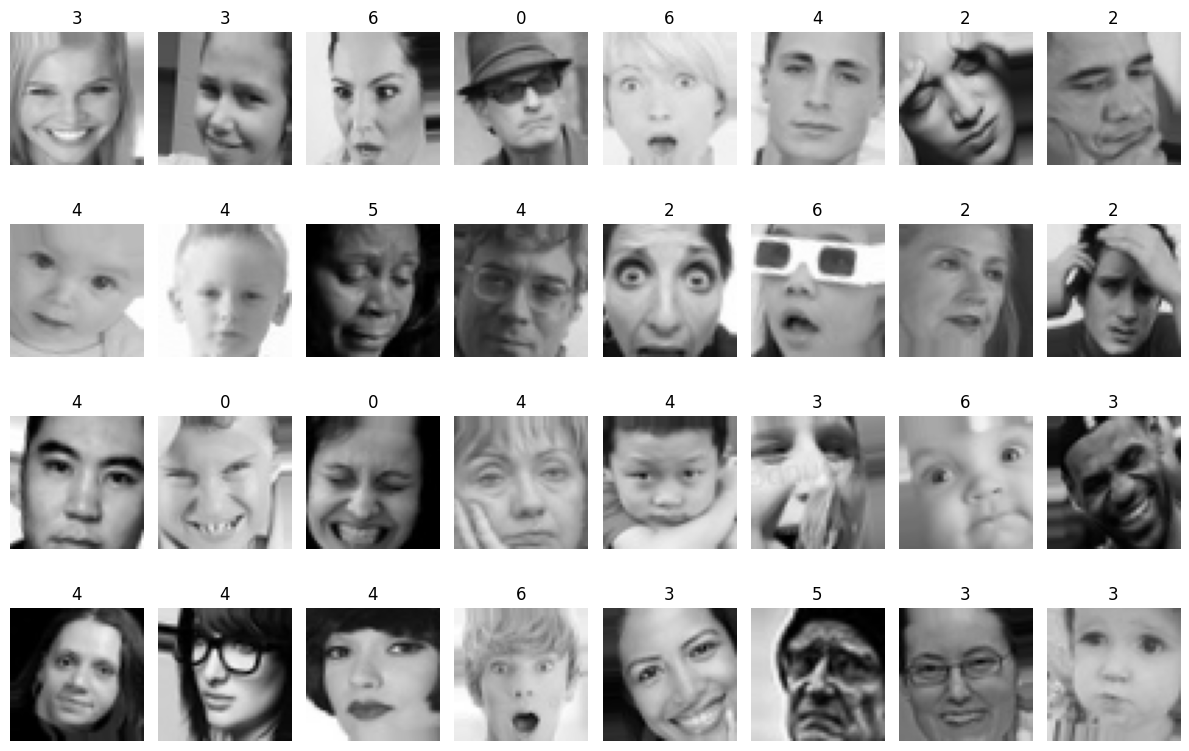

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of images and labels from train_generator
x_batch, y_batch = next(train_generator)

# Print the images and labels for train_generator
fig, axes = plt.subplots(4, 8, figsize=(12, 8))
axes = axes.ravel()
for i in range(32):
    axes[i].imshow(np.squeeze(x_batch[i]), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(np.argmax(y_batch[i]))
plt.tight_layout()
plt.show()



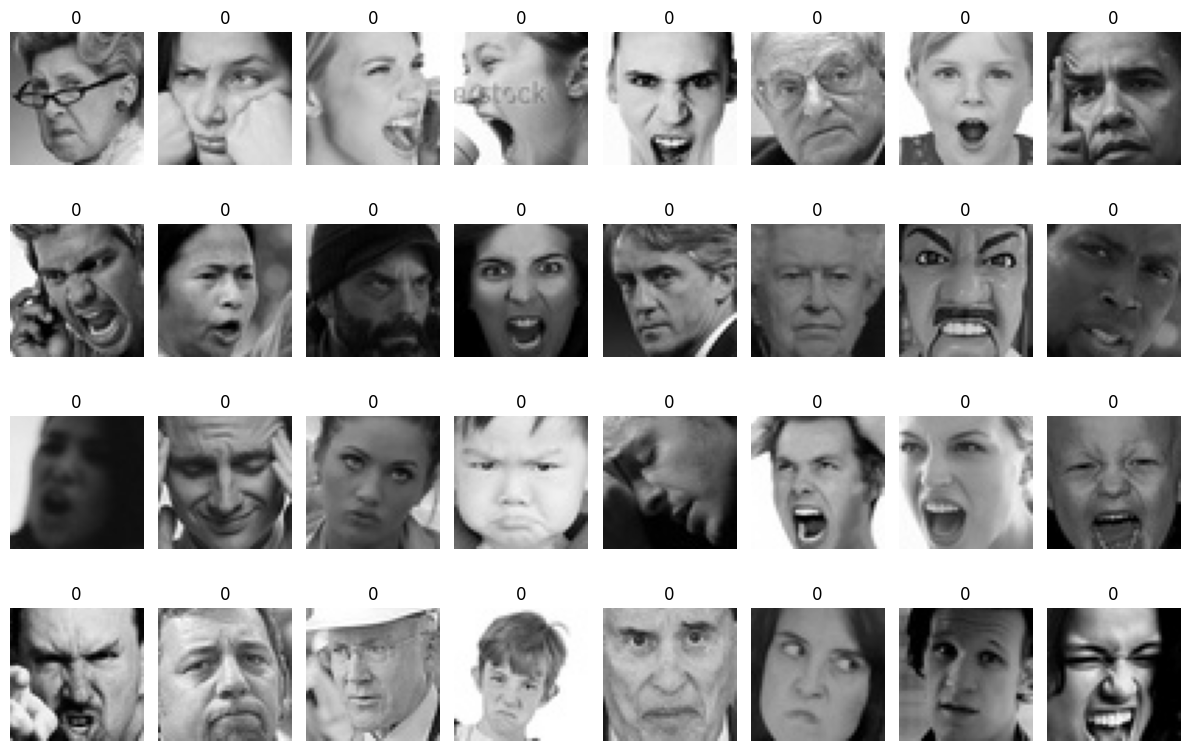

In [ ]:
# Get a batch of images and labels from validation_generator
x_batch, y_batch = next(validation_generator)

# Print the images and labels for validation_generator
fig, axes = plt.subplots(4, 8, figsize=(12, 8))
axes = axes.ravel()
for i in range(32):
    axes[i].imshow(np.squeeze(x_batch[i]), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(np.argmax(y_batch[i]))
plt.tight_layout()
plt.show()


In [ ]:
num_classes = 7
img_rows, img_cols = 48, 48

model = Sequential()

# Block-1
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(img_rows, img_cols, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block-2
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block-3
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block-4
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block-5
model.add(Flatten())
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-6
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-7
model.add(Dense(num_classes, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                        

In [ ]:

import numpy as np
from sklearn.utils import compute_class_weight

# Get the true class labels from the generator
train_labels = train_generator.classes

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(zip(np.unique(train_labels), class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 1.0321193387985486, 1: 9.458128078817735, 2: 1.0031784734619236, 3: 0.5746209098164405, 4: 0.8261617900172117, 5: 0.8332730560578662, 6: 1.2857142857142858}


In [ ]:
# from keras import backend as K
# def weighted_categorical_crossentropy(weights):
#     """
#     A weighted version of keras.objectives.categorical_crossentropy

#     Variables:
#         weights: numpy array of shape (C,) where C is the number of classes

#     Usage:
#         weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
#         loss = weighted_categorical_crossentropy(weights)
#         model.compile(loss=loss,optimizer='adam')
#     """

#     weights = K.variable(weights)

#     def loss(y_true, y_pred):
#         # scale predictions so that the class probas of each sample sum to 1
#         y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
#         # clip to prevent NaN's and Inf's
#         y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#         # calc
#         loss = y_true * K.log(y_pred) * weights
#         loss = -K.sum(loss, -1)
#         return loss

#     return loss

In [ ]:
# # Define the class weights (adjust these values accordingly)
# class_weights = np.array([  0.9912646149711061,  9.083743842364532,  1.0874244434615952, 0.5478583807873236,  0.7960571284671007,  0.9270213657310431,  1.2479837572612937])  # Example weights for three classes

# # Create the weighted loss function
# weighted_loss = weighted_categorical_crossentropy(class_weights)


weighted_categorical_crossentropy

In [ ]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping

# # ... (previous code for model creation and compilation)

# # Define early stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Monitor validation loss
#     patience=5,  # Number of epochs with no improvement before stopping
#     verbose=1,  # Print messages about early stopping
#     restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
# )

In [ ]:
checkpoint = ModelCheckpoint('Emotion_little_vgg.h5',
                             monitor='val_loss',
                             mode='auto',
                             save_best_only=True,
                             verbose=0)

callbacks = [checkpoint]

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

epochs = 10

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weights
)


Epoch 1/10


<ipython-input-18-497a0ea24b2d>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


720/720 [==============================] - 50s 59ms/step - loss: 0.9440 - accuracy: 0.6292 - val_loss: 1.0199 - val_accuracy: 0.6238
Epoch 2/10
720/720 [==============================] - 41s 57ms/step - loss: 0.9413 - accuracy: 0.6313 - val_loss: 1.0105 - val_accuracy: 0.6212
Epoch 3/10
720/720 [==============================] - 42s 59ms/step - loss: 0.9501 - accuracy: 0.6306 - val_loss: 1.1041 - val_accuracy: 0.5925
Epoch 4/10
720/720 [==============================] - 47s 65ms/step - loss: 0.9427 - accuracy: 0.6369 - val_loss: 0.9970 - val_accuracy: 0.6267
Epoch 5/10
720/720 [==============================] - 45s 63ms/step - loss: 0.9366 - accuracy: 0.6336 - val_loss: 1.0457 - val_accuracy: 0.6139
Epoch 6/10
720/720 [==============================] - 46s 64ms/step - loss: 0.9324 - accuracy: 0.6326 - val_loss: 1.0265 - val_accuracy: 0.6198
Epoch 7/10
720/720 [==============================] - 48s 66ms/step - loss: 0.9286 - accuracy: 0.6362 - val_loss: 0.9965 - val_accuracy: 0.6240
Epo

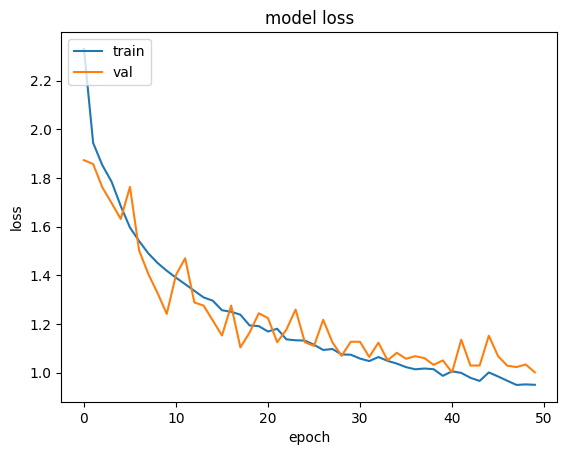

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

181/181 [==============================] - 3s 18ms/step - loss: 1.0019 - accuracy: 0.6280
Test Loss: 1.001943588256836
Test Accuracy: 0.6279916763305664


181/181 [==============================] - 3s 15ms/step


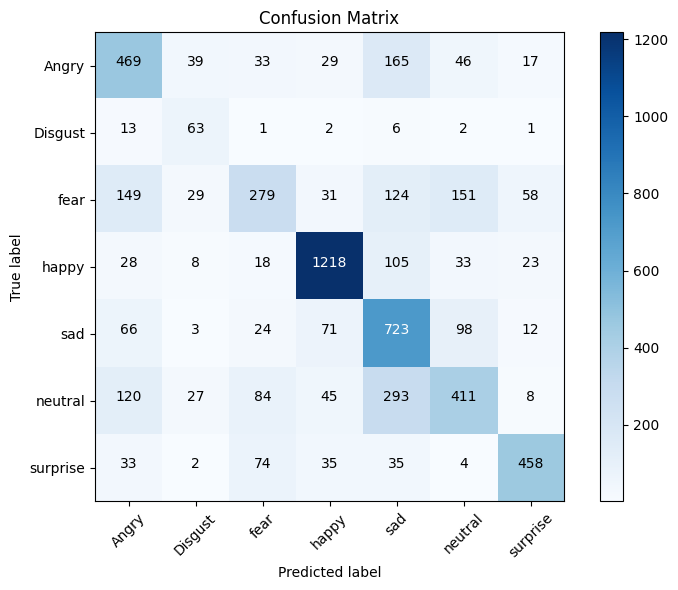

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate predictions for the test data
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ['Angry', 'Disgust', 'fear', 'happy', 'sad','neutral', 'surprise']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Fill the matrix with values and labels
thresh = confusion_mat.max() / 2.0
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


181/181 [==============================] - 3s 18ms/step


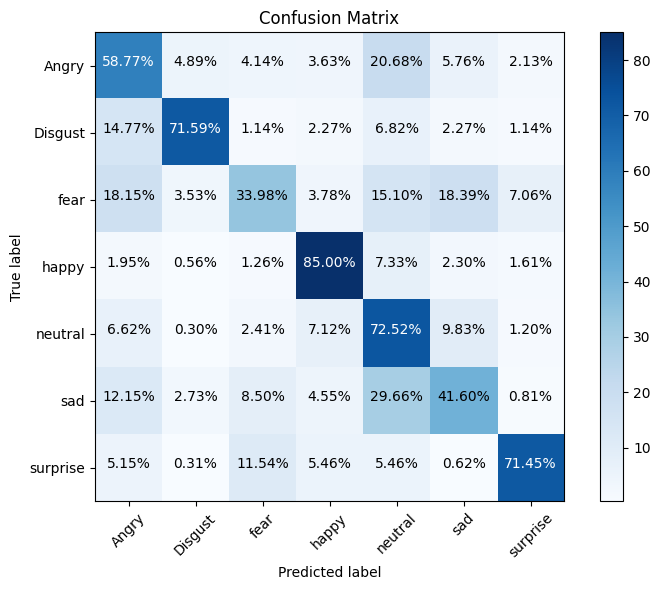

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate predictions for the test data
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Calculate the percentage values in the confusion matrix
confusion_mat_percentage = confusion_mat / confusion_mat.sum(axis=1)[:, np.newaxis] * 100

# Define class labels
class_labels = ['Angry', 'Disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mat_percentage, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Fill the matrix with percentage values and labels
thresh = confusion_mat_percentage.max() / 2.0
for i in range(confusion_mat_percentage.shape[0]):
    for j in range(confusion_mat_percentage.shape[1]):
        plt.text(j, i, format(confusion_mat_percentage[i, j], '.2f') + '%',
                 horizontalalignment="center",
                 color="white" if confusion_mat_percentage[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


* Test Time Agumentation

In [ ]:
# Define augmented parameters for TTA
tta_datagen = ImageDataGenerator(
     rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

preprocessed = "/content/fer/images/validation"

# Flow test images from the preprocessed test folder with TTA
tta_generator = tta_datagen.flow_from_directory(
    preprocessed,
    target_size=input_shape[:2],
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

num_augmentations = 15

# Initialize an array to store predictions for TTA
test_predictions_sum = np.zeros((tta_generator.samples, num_classes))

# Generate predictions using TTA for test data
for _ in range(num_augmentations):
    test_predictions = model.predict_generator(
        tta_generator,
        steps=tta_generator.samples // tta_generator.batch_size,
        verbose=1
    )
    test_predictions_sum[:test_predictions.shape[0]] += test_predictions

# Average the predictions for test data
test_predictions_avg = test_predictions_sum / num_augmentations

# Convert the predicted probabilities to class labels for test data
test_predicted_labels = np.argmax(test_predictions_avg, axis=1)

# ... (calculate and print test accuracy and other evaluations if needed)
# ... (calculate and print test accuracy and other evaluations if needed)
from sklearn.metrics import classification_report, confusion_matrix

# Calculate and print test accuracy
test_accuracy = np.mean(test_predicted_labels == tta_generator.classes)
print("Test Accuracy (with TTA): {:.2f}%".format(test_accuracy * 100))

# # Calculate and print classification report
# class_names = list(tta_generator.class_indices.keys())
# print("Classification Report:\n")
# print(classification_report(tta_generator.classes, test_predicted_labels, target_names=class_names))

# Calculate and print confusion matrix
confusion = confusion_matrix(tta_generator.classes, test_predicted_labels)
print("Confusion Matrix:\n")
print(confusion)


Found 7066 images belonging to 7 classes.
  1/220 [..............................] - ETA: 15s

<ipython-input-16-1ecdc5fd4751>:32: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = model.predict_generator(


220/220 [==============================] - 10s 46ms/step
Test Accuracy (with TTA): 64.35%
Confusion Matrix:

[[ 507   65   53   30  180  111   14]
 [  11   90    4    1    3    2    0]
 [ 161   26  346   45  162  203   75]
 [  31    8   20 1569  114   46   37]
 [  47    5   26   98  914  115   11]
 [ 125   30   83   44  305  541   11]
 [  38    7   84   38   42    8  580]]


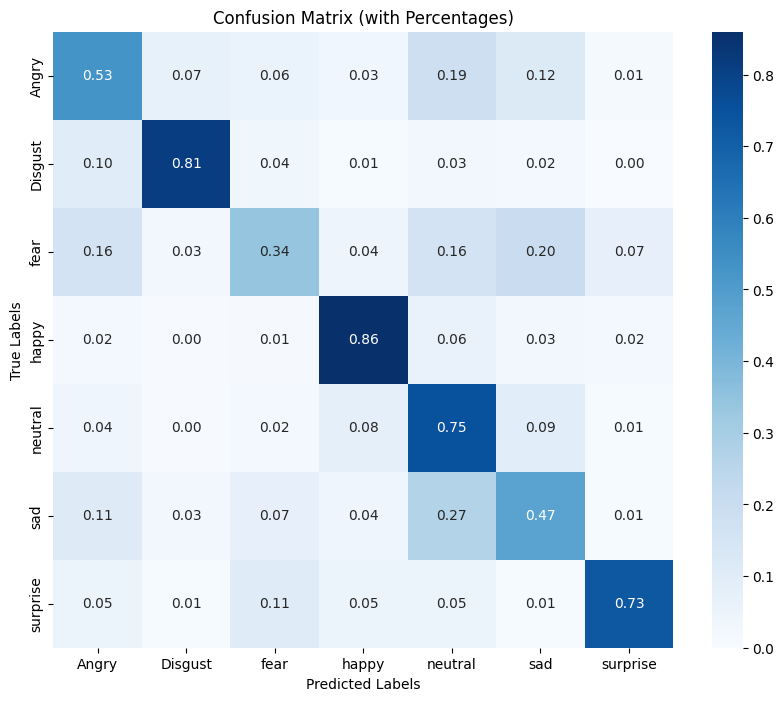

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# ... (previous code)

# Calculate the confusion matrix with percentages
confusion_percent = confusion / confusion.sum(axis=1, keepdims=True)
class_names = ['Angry', 'Disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_percent,
    annot=True,
    fmt=".2f",  # Display percentages with two decimal places
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion Matrix (with Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
